#University of San Diego - AAI-530(02) *Data Analytics and Internet of Things*

**FINAL TEAM PROJECT**

**TEAM 2:** *Arifa Kokab, Muhammad Haris and Tyler Clinscales*

#Harvest Sense: *AI-Driven Crop Yield and Soil Quality Prediction*

**Implementation of LSTM and Random Forest Models for Precision Agriculture**

This code presents the development and deployment of advanced machine learning models to enhance agricultural decision-making through predictive analytics.

The LSTM (Long Short-Term Memory) model is employed to forecast crop yield per crop type by analyzing historical data, environmental factors, and soil conditions, capturing complex temporal dependencies for more accurate predictions. Simultaneously, the Random Forest model is used to assess soil quality per crop type, leveraging ensemble learning techniques to identify key soil attributes influencing agricultural productivity.

By integrating these models, Harvest Sense provides a robust framework for precision agriculture, enabling farmers and stakeholders to make data-driven decisions regarding crop selection, resource allocation, and sustainability practices. These predictive insights help optimize yield, improve soil health, and enhance overall agricultural efficiency, making farming more resilient to environmental fluctuations.

#Dataset Overview: Comprehensive Crop Yield and Environmental Factors (2014-2023)

This dataset provides a detailed, synthetic representation of crop yield and the environmental factors influencing agricultural productivity over a decade (2014-2023). It contains daily observations, making it highly valuable for time-series forecasting, predictive modeling, and data-driven agricultural insights. The dataset includes ten major crops—such as Wheat, Corn, Rice, and Sugarcane—grown across five different soil types with varying nutrient levels (NPK), soil pH, temperature, humidity, and wind speed. These features allow for a granular understanding of how different environmental conditions impact crop yield and soil quality over time.

The dataset was generated using a domain-specific synthetic modeling approach, incorporating real-world agricultural principles. Soil pH levels were assigned based on natural ranges, NPK nutrient levels were adjusted according to crop-specific needs, and seasonal temperature and humidity trends were factored into the data generation process. The crop yield metric (in metric tons per hectare) was estimated using a predictive model that considers nutrient availability, temperature suitability, and humidity levels. Similarly, a soil quality index was derived to measure the fertility and health of the soil based on its nutrient composition and pH balance.

This dataset is ideal for predictive modeling, climate impact analysis, soil and crop management strategies, and data visualization applications. It enables researchers and data scientists to explore relationships between environmental variables, develop AI-driven forecasting models, and create insightful dashboards for decision-making. Although synthetic in nature, the dataset follows structured agricultural modeling techniques, making it a valuable tool for academic research, machine learning applications, and precision agriculture advancements.

Link to dataset: www.kaggle.com/datasets/madhankumar789/crop-yield-and-environmental-factors-2014-2023

Import Necessary Libraries

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load Data and Initial Exploration

In [4]:
# Path of file in Google Drive
file_path = '/content/drive/My Drive/crop_yield_dataset.csv'

# Load the dataset
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(data.head())

# Display a concise summary of the dataframe
print("\nDataset Info:")
data.info()

# Describe the numerical features to get mean, count, std, etc.
print("\nStatistics for numerical features:")
print(data.describe())

# Describe the categorical features
print("\nStatistics for categorical features:")
print(data.describe(include=['object', 'bool']))

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

First few rows of the dataset:
         Date Crop_Type Soil_Type  Soil_pH  Temperature   Humidity  \
0  2014-01-01     Wheat     Peaty     5.50     9.440599  80.000000   
1  2014-01-01      Corn     Loamy     6.50    20.052576  79.947424   
2  2014-01-01      Rice     Peaty     5.50    12.143099  80.000000   
3  2014-01-01    Barley     Sandy     6.75    19.751848  80.000000   
4  2014-01-01   Soybean     Peaty     5.50    16.110395  80.000000   

   Wind_Speed     N     P     K  Crop_Yield  Soil_Quality  
0   10.956707  60.5  45.0  31.5    0.000000     22.833333  
1    8.591577  84.0  66.0  50.0  104.871310     66.666667  
2    7.227751  71.5  54.0  38.5    0.000000     27.333333  
3    2.682683  50.0  40.0  30.0   58.939796     35.000000  
4    7.696070  49.5  45.0  38.5   32.970413     22.166667  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36520 entries, 0 to 36519
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --

In [5]:
print(data.columns)

Index(['Date', 'Crop_Type', 'Soil_Type', 'Soil_pH', 'Temperature', 'Humidity',
       'Wind_Speed', 'N', 'P', 'K', 'Crop_Yield', 'Soil_Quality'],
      dtype='object')


Data Preprocessing and Feature Engineering

In [6]:
#############################################
# 1. Data Preprocessing & Feature Engineering
#############################################

# Convert Date column to datetime and sort the data chronologically
data['Date'] = pd.to_datetime(data['Date'])
data.sort_values('Date', inplace=True)

# Preserve the original Crop_Type for grouping later
data['Crop_Type_Orig'] = data['Crop_Type']

# Extract additional date features
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# One-hot encode categorical variables (Crop_Type and Soil_Type)
data = pd.get_dummies(data, columns=['Crop_Type', 'Soil_Type'])

# Scale numerical features – useful for neural network training.
num_features = ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Crop_Yield', 'Soil_Quality']
scaler = StandardScaler()
data[num_features] = scaler.fit_transform(data[num_features])

# Create a duplicate of the processed data for later use (e.g., Tableau dashboard)
processed_data = data.copy()
processed_data.to_csv('processed_data.csv', index=False)
print("Processed data saved as 'processed_data.csv'.")

Processed data saved as 'processed_data.csv'.


Exploratory Data Analysis with Visualizations

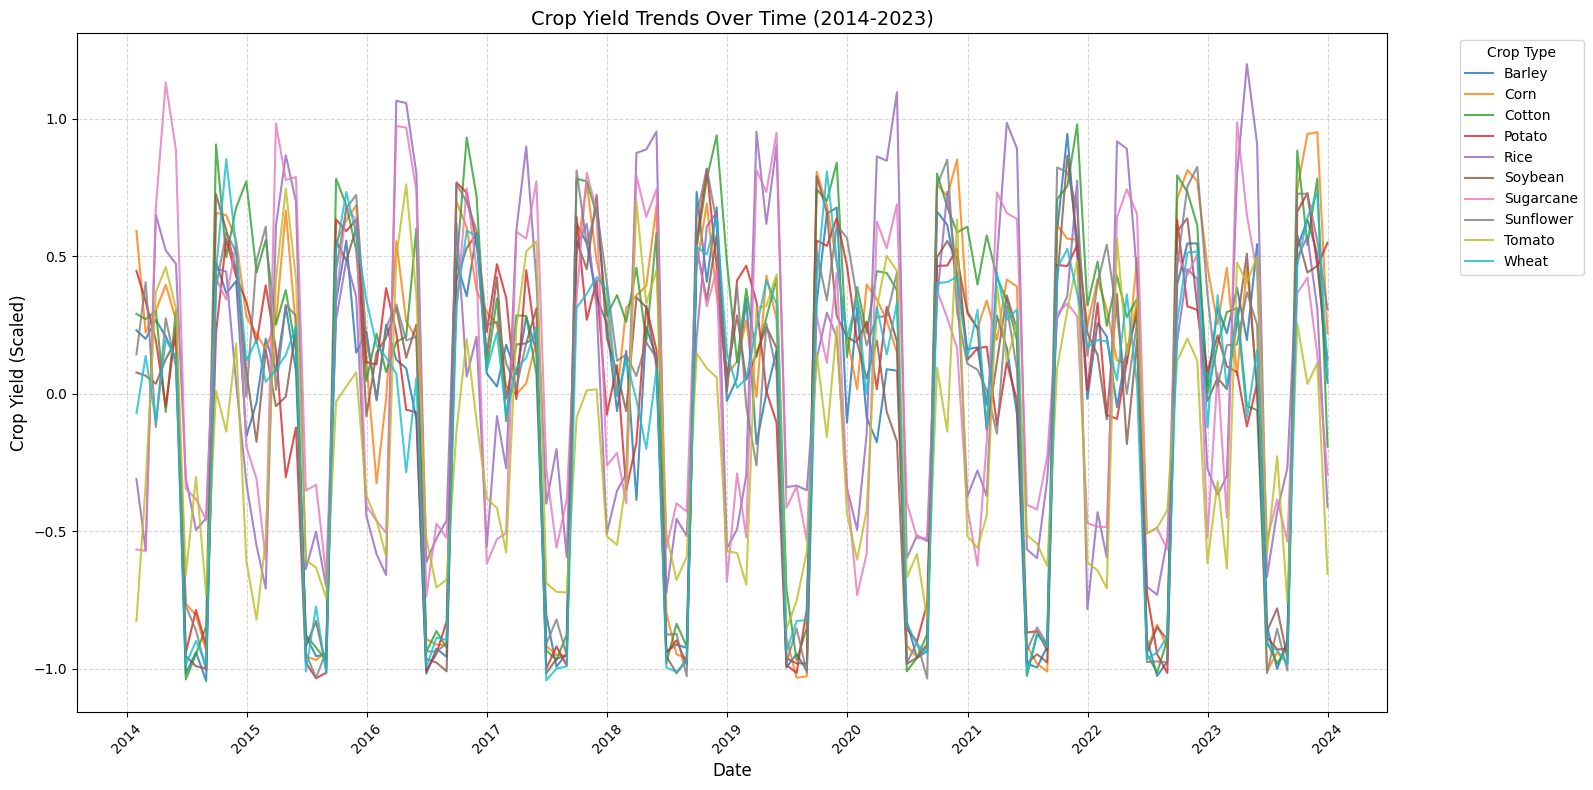

In [30]:
# Ensure the Date column is in datetime format
processed_data['Date'] = pd.to_datetime(processed_data['Date'])

# Resample data to monthly averages by grouping on the original crop type and month-end dates
data_resampled = processed_data.groupby(['Crop_Type_Orig', pd.Grouper(key='Date', freq='ME')])['Crop_Yield'].mean().reset_index()

# Plot the line graph
plt.figure(figsize=(16, 8))
sns.lineplot(data=data_resampled, x='Date', y='Crop_Yield', hue='Crop_Type_Orig', palette='tab10', alpha=0.8)
plt.title("Crop Yield Trends Over Time (2014-2023)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Crop Yield (Scaled)", fontsize=12)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend(title="Crop Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

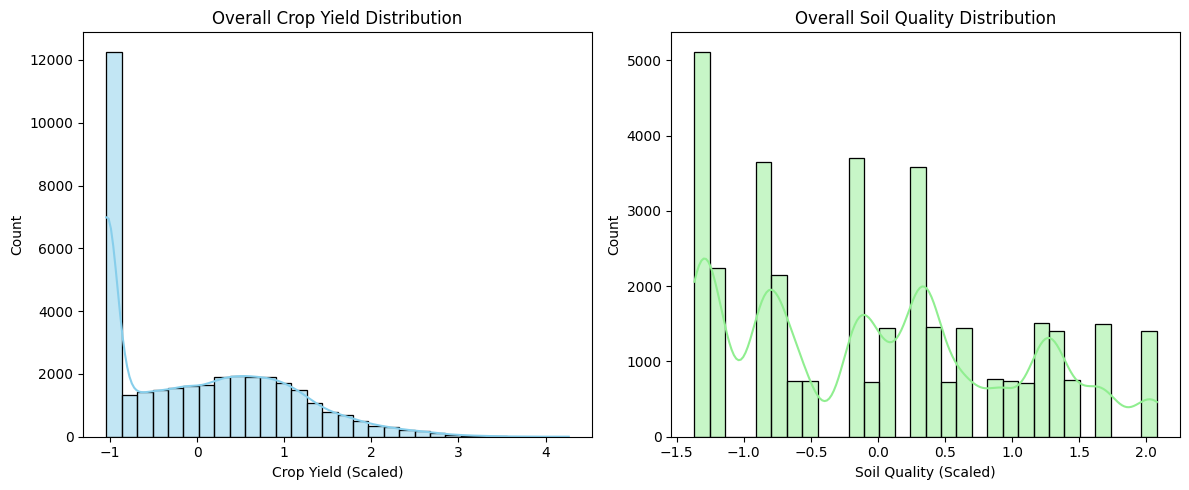

In [31]:
#Distribution Plots for Crop Yield and Soil Quality

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(processed_data['Crop_Yield'], kde=True, bins=30, color='skyblue')
plt.title("Overall Crop Yield Distribution")
plt.xlabel("Crop Yield (Scaled)")

plt.subplot(1, 2, 2)
sns.histplot(processed_data['Soil_Quality'], kde=True, bins=30, color='lightgreen')
plt.title("Overall Soil Quality Distribution")
plt.xlabel("Soil Quality (Scaled)")

plt.tight_layout()
plt.show()

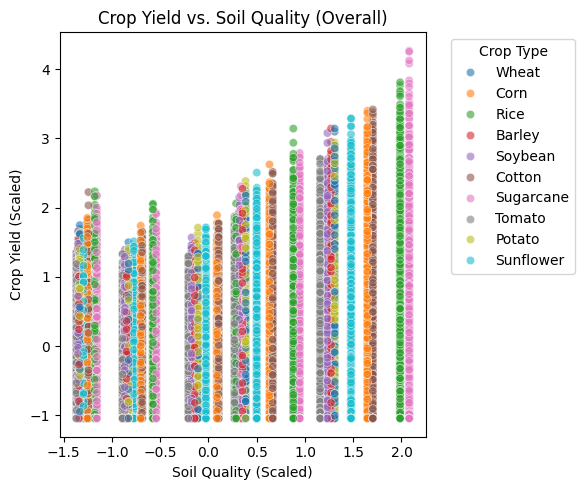

In [32]:
#Scatter Plot: Crop Yield vs. Soil Quality
plt.figure(figsize=(6, 5))
sns.scatterplot(data=processed_data, x='Soil_Quality', y='Crop_Yield', hue='Crop_Type_Orig', alpha=0.6)
plt.title("Crop Yield vs. Soil Quality (Overall)")
plt.xlabel("Soil Quality (Scaled)")
plt.ylabel("Crop Yield (Scaled)")
plt.legend(title='Crop Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

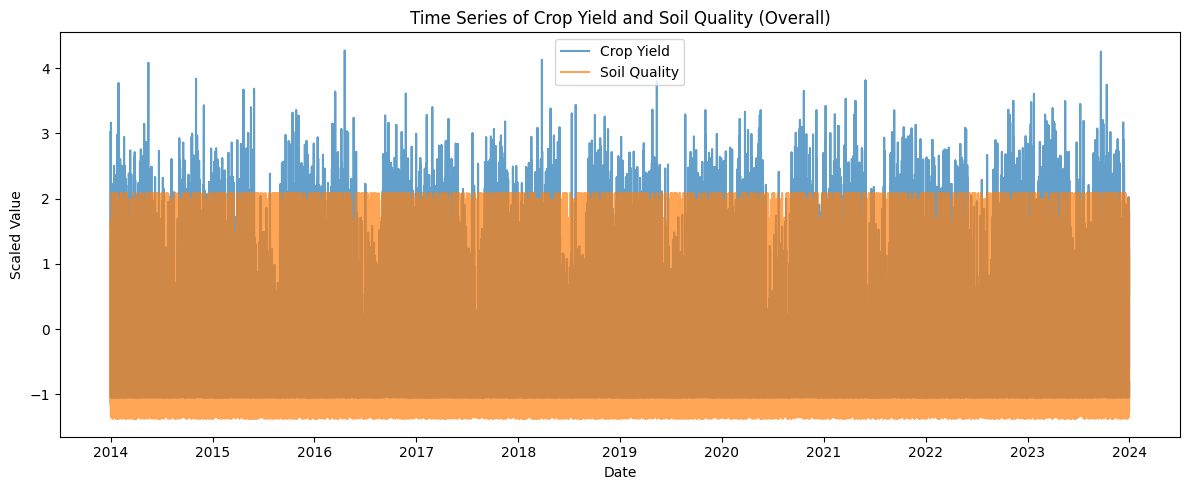

In [33]:
#Time Series Plot: Crop Yield and Soil Quality Over Time
plt.figure(figsize=(12, 5))
plt.plot(processed_data['Date'], processed_data['Crop_Yield'], label='Crop Yield', alpha=0.7)
plt.plot(processed_data['Date'], processed_data['Soil_Quality'], label='Soil Quality', alpha=0.7)
plt.title("Time Series of Crop Yield and Soil Quality (Overall)")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.legend()
plt.tight_layout()
plt.show()

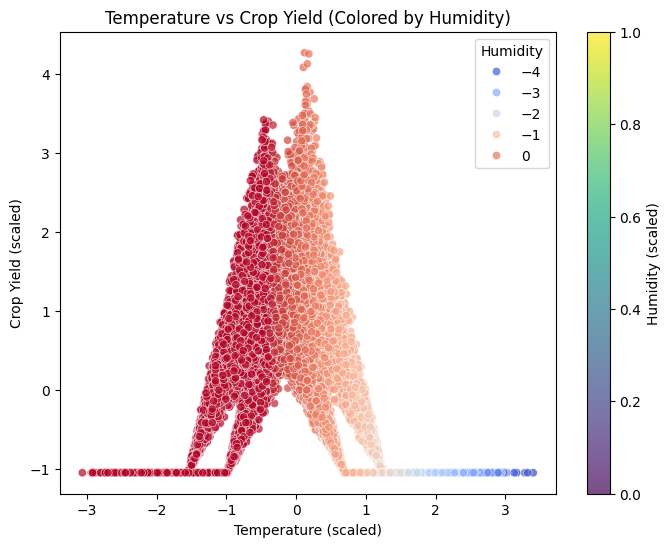

In [35]:
# Plot Temperature vs Crop Yield colored by Humidity using processed_data
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=processed_data, x="Temperature", y="Crop_Yield",
                hue="Humidity", palette="coolwarm", alpha=0.7, ax=ax)
plt.title("Temperature vs Crop Yield (Colored by Humidity)")
plt.xlabel("Temperature (scaled)")
plt.ylabel("Crop Yield (scaled)")
plt.colorbar(ax.collections[0], label="Humidity (scaled)")
plt.show()

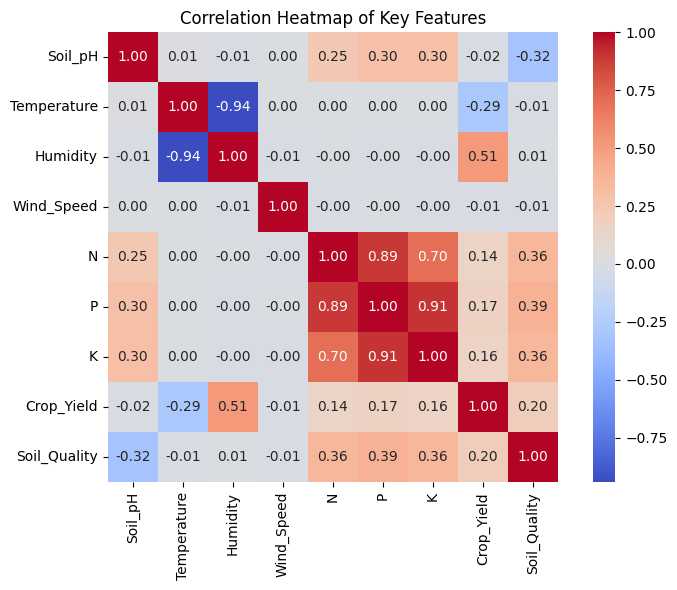

In [34]:
#Correlation Heatmap of Key Numerical Features
num_features = ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Crop_Yield', 'Soil_Quality']
corr = processed_data[num_features].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of Key Features")
plt.tight_layout()
plt.show()

Model Development and Training for LSTM Model to predict Crop Yield per Crop Type 6 months into the future


Training LSTM model for crop: Wheat
Wheat - Validation MSE: 0.6906, MAE: 0.6247


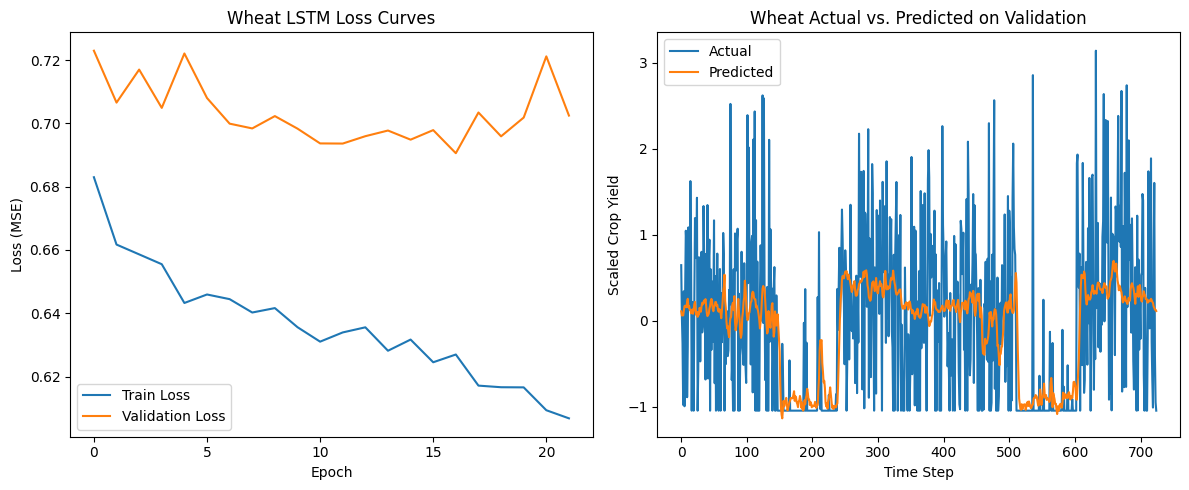

Forecast for Wheat saved as 'wheat_crop_yield_forecast.csv'.

Training LSTM model for crop: Corn
Corn - Validation MSE: 0.8067, MAE: 0.6879


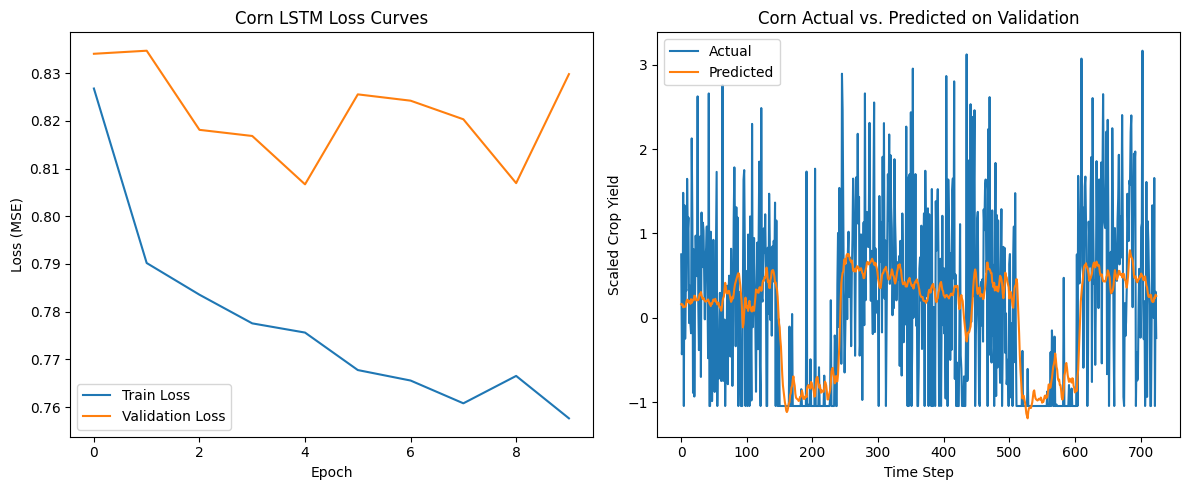

Forecast for Corn saved as 'corn_crop_yield_forecast.csv'.

Training LSTM model for crop: Rice
Rice - Validation MSE: 0.9710, MAE: 0.7863


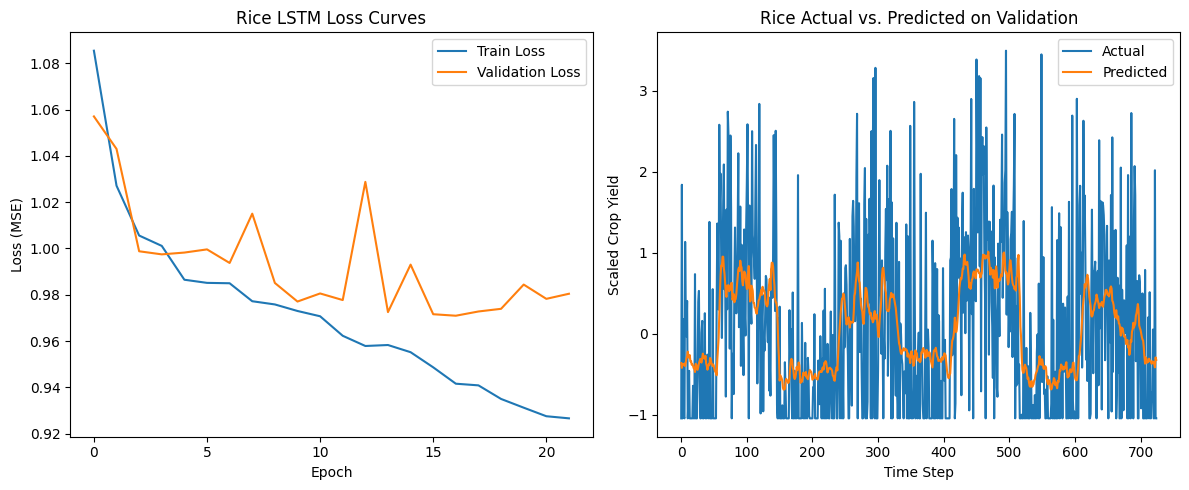

Forecast for Rice saved as 'rice_crop_yield_forecast.csv'.

Training LSTM model for crop: Barley
Barley - Validation MSE: 0.6113, MAE: 0.5995


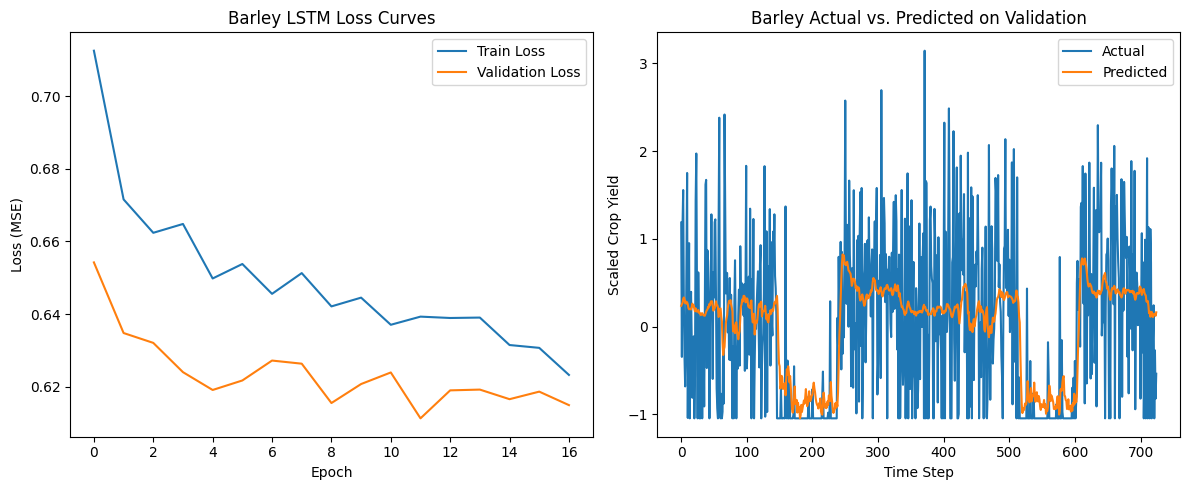

Forecast for Barley saved as 'barley_crop_yield_forecast.csv'.

Training LSTM model for crop: Soybean
Soybean - Validation MSE: 0.6435, MAE: 0.6149


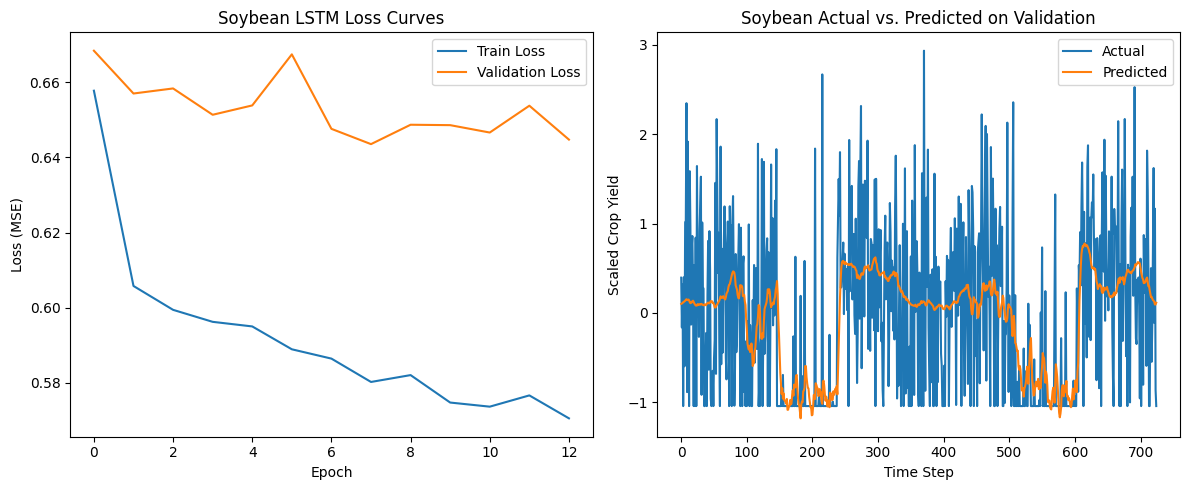

Forecast for Soybean saved as 'soybean_crop_yield_forecast.csv'.

Training LSTM model for crop: Cotton
Cotton - Validation MSE: 0.8284, MAE: 0.7053


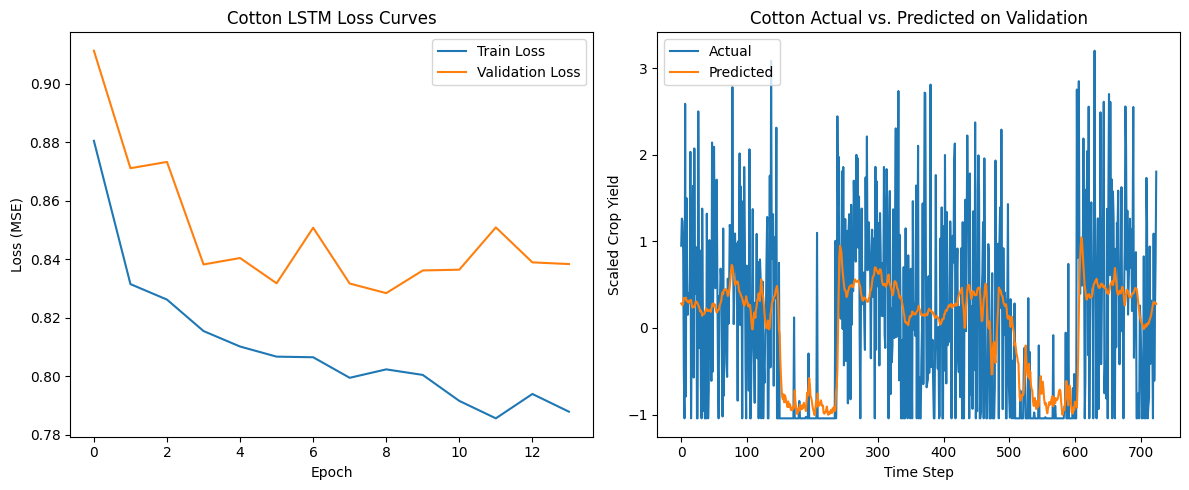

Forecast for Cotton saved as 'cotton_crop_yield_forecast.csv'.

Training LSTM model for crop: Sugarcane
Sugarcane - Validation MSE: 1.0184, MAE: 0.8125


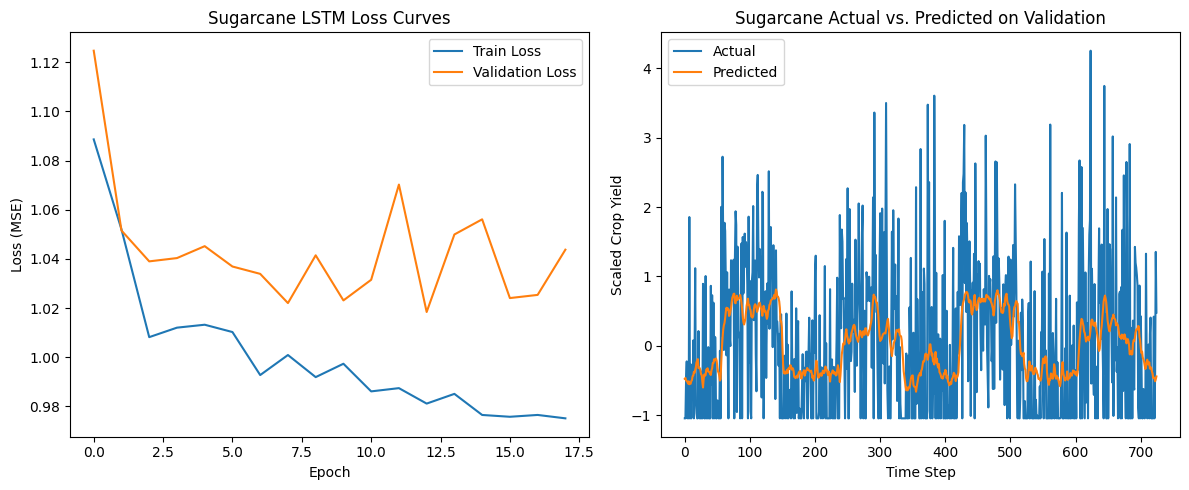

Forecast for Sugarcane saved as 'sugarcane_crop_yield_forecast.csv'.

Training LSTM model for crop: Tomato
Tomato - Validation MSE: 0.6654, MAE: 0.6838


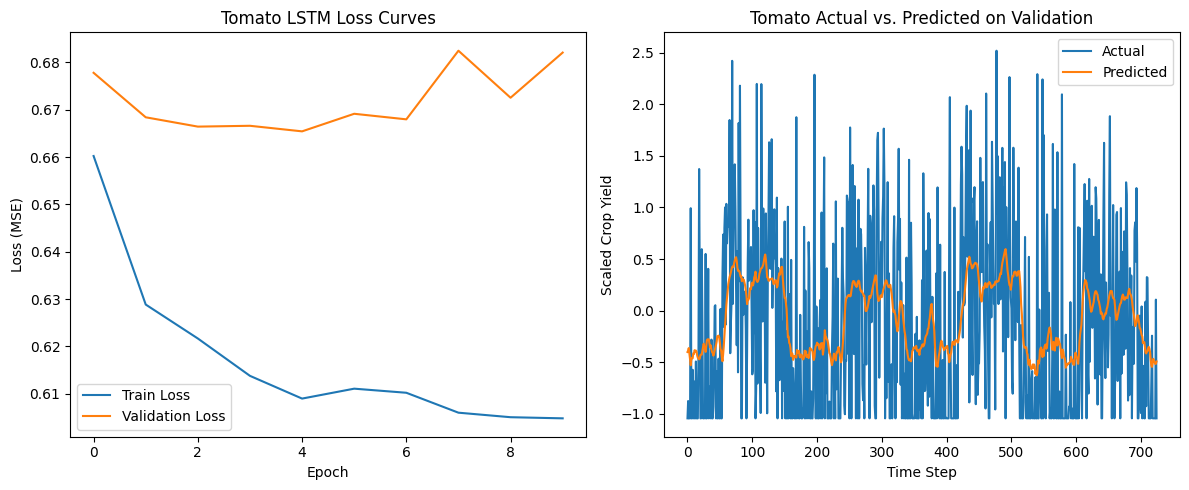

Forecast for Tomato saved as 'tomato_crop_yield_forecast.csv'.

Training LSTM model for crop: Potato
Potato - Validation MSE: 0.6272, MAE: 0.6145


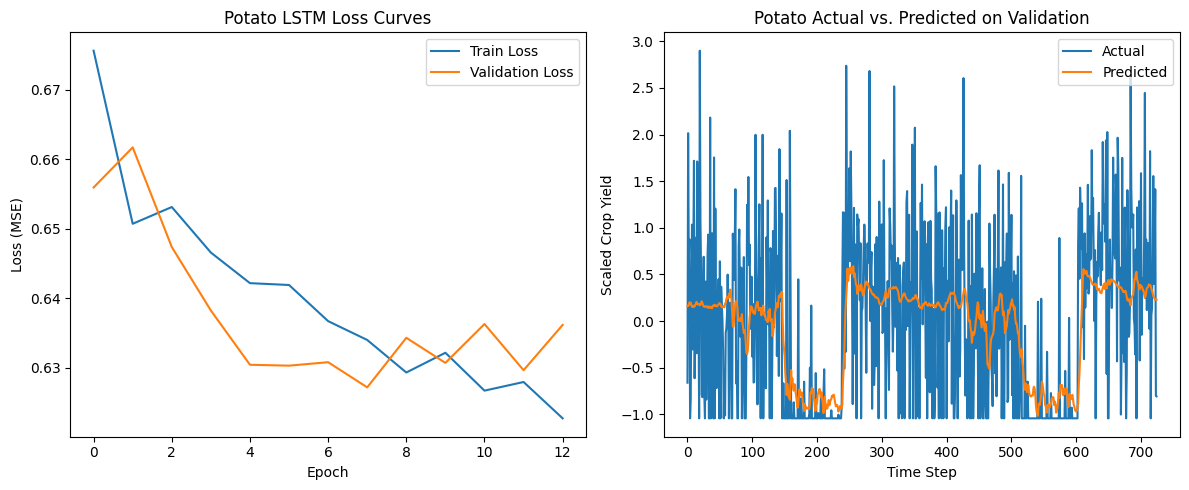

Forecast for Potato saved as 'potato_crop_yield_forecast.csv'.

Training LSTM model for crop: Sunflower
Sunflower - Validation MSE: 0.7516, MAE: 0.6551


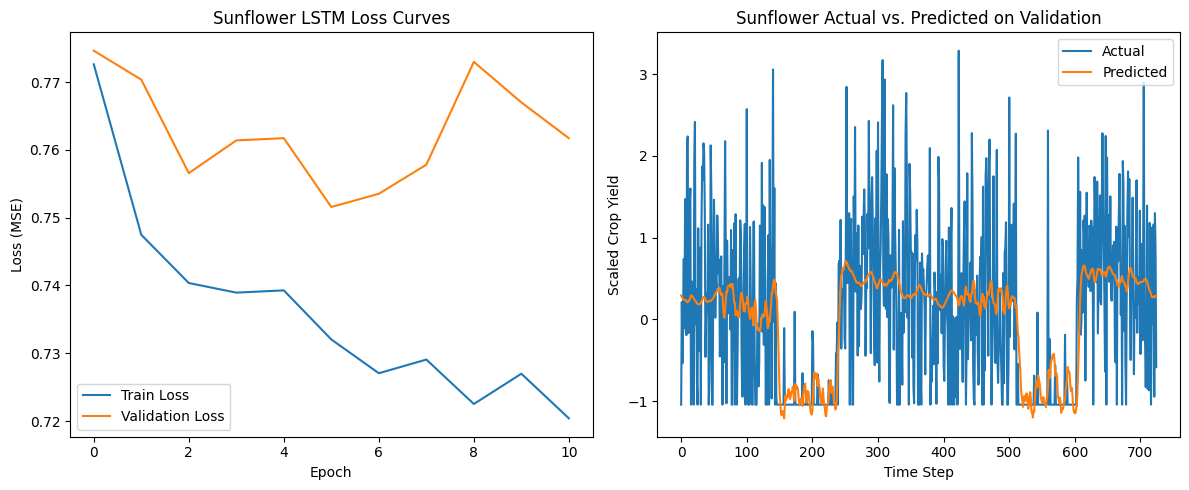

Forecast for Sunflower saved as 'sunflower_crop_yield_forecast.csv'.
Combined crop yield forecasts saved as 'all_crop_yield_forecasts.csv'.


In [10]:
#############################################
# 2. LSTM Model Training and Visualization for Each Crop Type
#############################################

# Helper function to create sequences for LSTM training.
def create_sequences(df, seq_length, feature_cols, target_col):
    X, y = [], []
    for i in range(len(df) - seq_length):
        X.append(df[feature_cols].iloc[i:i+seq_length].values)
        y.append(df[target_col].iloc[i+seq_length])
    return np.array(X), np.array(y)

# Define features and target for LSTM.
features = ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K']
target = 'Crop_Yield'
seq_length = 30       # Using the past 30 days to predict the next day.
num_future_days = 180 # Not used in visualization, but available for forecasting if needed.

# Get unique crop types (using the preserved original column)
unique_crop_types = processed_data['Crop_Type_Orig'].unique()

for crop in unique_crop_types:
    print(f"\nTraining LSTM model for crop: {crop}")
    # Filter data for the current crop type
    crop_data = processed_data[processed_data['Crop_Type_Orig'] == crop].copy()
    crop_data.sort_values('Date', inplace=True)
    crop_data.reset_index(drop=True, inplace=True)

    # Ensure sufficient data exists for sequence creation.
    if len(crop_data) < seq_length + 1:
        print(f"Not enough data for crop: {crop}. Skipping.")
        continue

    # Create sequences
    X, y = create_sequences(crop_data, seq_length, features, target)
    if len(X) == 0:
        print(f"Sequence creation failed for crop: {crop}. Skipping.")
        continue

    # Split sequences into training and validation sets.
    split_index = int(0.8 * len(X))
    X_train, X_val = X[:split_index], X[split_index:]
    y_train, y_val = y[:split_index], y[split_index:]

    # Define the LSTM model using an explicit Input layer.
    model = Sequential([
        Input(shape=(seq_length, len(features))),
        LSTM(64, return_sequences=True, activation='tanh'),
        Dropout(0.2),
        LSTM(32, activation='tanh'),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')

    # Setup early stopping to avoid overfitting.
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model and capture training history.
    history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_data=(X_val, y_val), callbacks=[early_stop], verbose=0)

    # Evaluate performance on validation set.
    y_pred = model.predict(X_val, verbose=0)
    mse_val = mean_squared_error(y_val, y_pred)
    mae_val = mean_absolute_error(y_val, y_pred)
    print(f"{crop} - Validation MSE: {mse_val:.4f}, MAE: {mae_val:.4f}")

    # Visualization: Loss curves and Actual vs. Predicted on validation set.
    plt.figure(figsize=(12, 5))

    # Plot training and validation loss curves.
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{crop} LSTM Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss (MSE)")
    plt.legend()

    # Plot Actual vs Predicted values on the validation set.
    plt.subplot(1, 2, 2)
    plt.plot(y_val, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(f"{crop} Actual vs. Predicted on Validation")
    plt.xlabel("Time Step")
    plt.ylabel("Scaled Crop Yield")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Forecast future crop yield for 6 months using iterative prediction.
    last_sequence = crop_data[features].iloc[-seq_length:].values  # shape: (seq_length, num_features)
    future_yield_preds = []
    current_seq = last_sequence.copy()

    for _ in range(num_future_days):
        # Predict the next day's crop yield.
        pred = model.predict(current_seq.reshape(1, seq_length, len(features)), verbose=0)
        future_yield_preds.append(pred[0, 0])

        # Update the sequence by shifting and using the last row as a placeholder.
        # In a real scenario, you should update all features based on external forecasts.
        new_row = current_seq[-1].copy()
        current_seq = np.vstack([current_seq[1:], new_row])

    # Create a DataFrame with future dates and predicted yield.
    last_date = crop_data['Date'].iloc[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(num_future_days)]
    crop_forecast_df = pd.DataFrame({
        'Date': future_dates,
        'Crop_Type': crop,
        'Predicted_Crop_Yield': future_yield_preds
    })

    # Save individual forecast to CSV.
    forecast_filename = f"{crop.lower().replace(' ', '_')}_crop_yield_forecast.csv"
    crop_forecast_df.to_csv(forecast_filename, index=False)
    print(f"Forecast for {crop} saved as '{forecast_filename}'.")

    all_crop_forecasts.append(crop_forecast_df)

# Optionally, combine all crop forecasts into a single CSV for dashboarding.
if all_crop_forecasts:
    combined_forecasts = pd.concat(all_crop_forecasts, ignore_index=True)
    combined_forecasts.to_csv('all_crop_yield_forecasts.csv', index=False)
    print("Combined crop yield forecasts saved as 'all_crop_yield_forecasts.csv'.")

In [12]:
# Download the CSV file
files.download("all_crop_yield_forecasts.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model Development and Training for Random Forest Model to predict Soil Quality per Crop Type 6 months into the future


Training Random Forest model for crop: Wheat
Best parameters for Wheat: {'max_depth': None, 'n_estimators': 50}
Wheat - Random Forest Test MSE: 0.0000, MAE: 0.0000


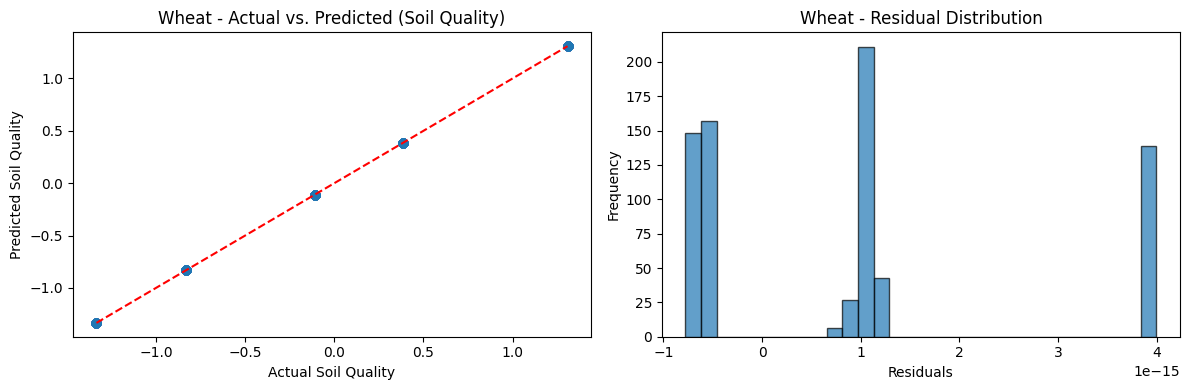

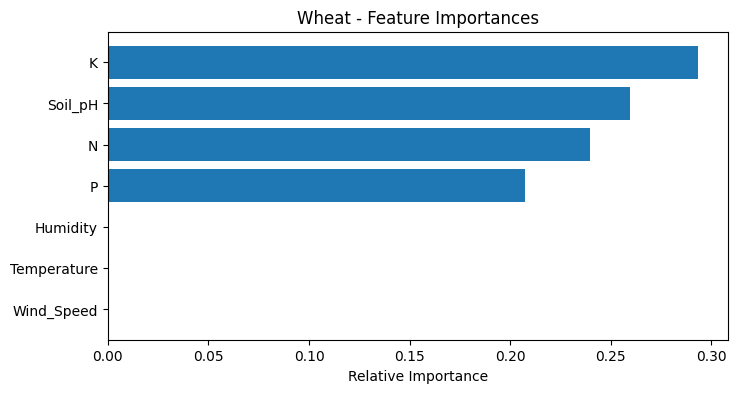

Soil quality forecast for Wheat saved as 'wheat_soil_quality_forecast.csv'.

Training Random Forest model for crop: Corn
Best parameters for Corn: {'max_depth': 5, 'n_estimators': 100}
Corn - Random Forest Test MSE: 0.0000, MAE: 0.0000


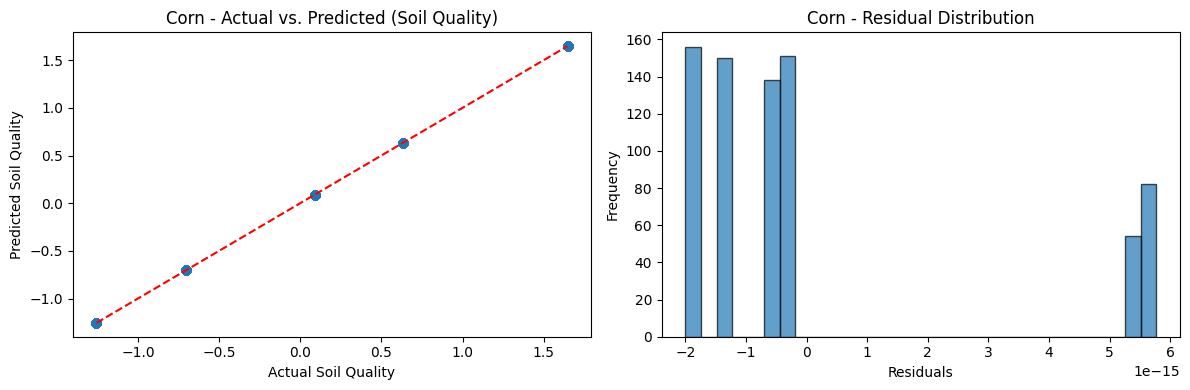

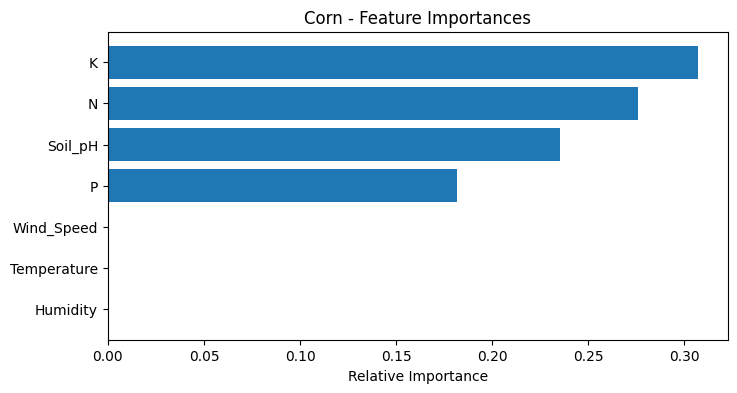

Soil quality forecast for Corn saved as 'corn_soil_quality_forecast.csv'.

Training Random Forest model for crop: Rice
Best parameters for Rice: {'max_depth': 10, 'n_estimators': 100}
Rice - Random Forest Test MSE: 0.0000, MAE: 0.0000


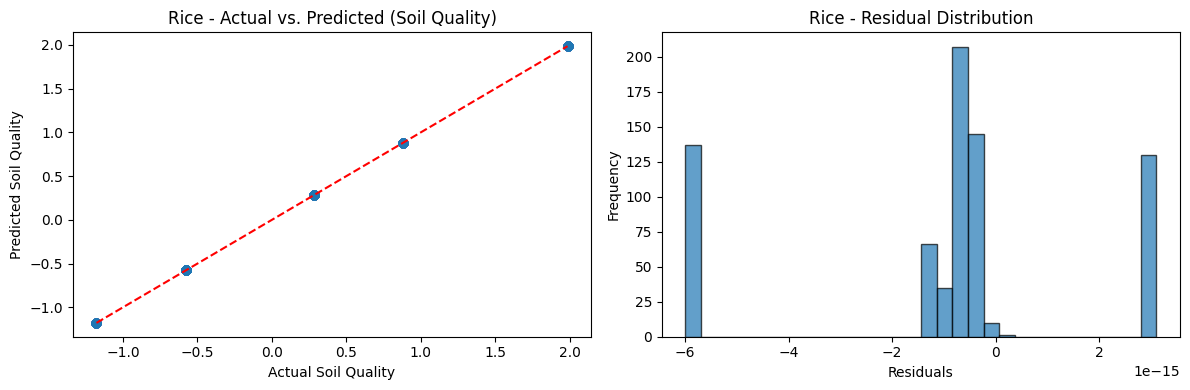

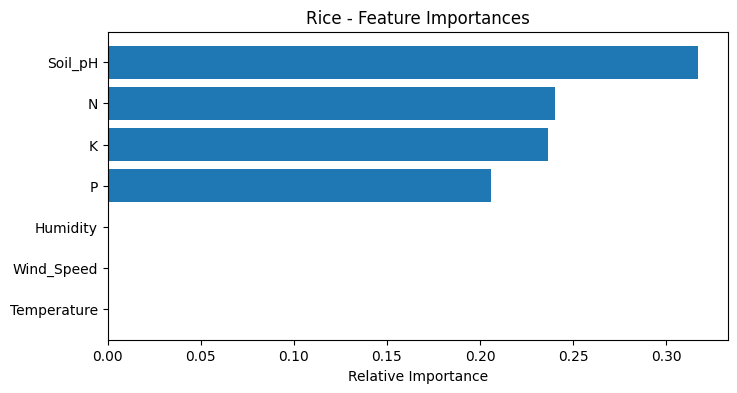

Soil quality forecast for Rice saved as 'rice_soil_quality_forecast.csv'.

Training Random Forest model for crop: Barley
Best parameters for Barley: {'max_depth': None, 'n_estimators': 50}
Barley - Random Forest Test MSE: 0.0000, MAE: 0.0000


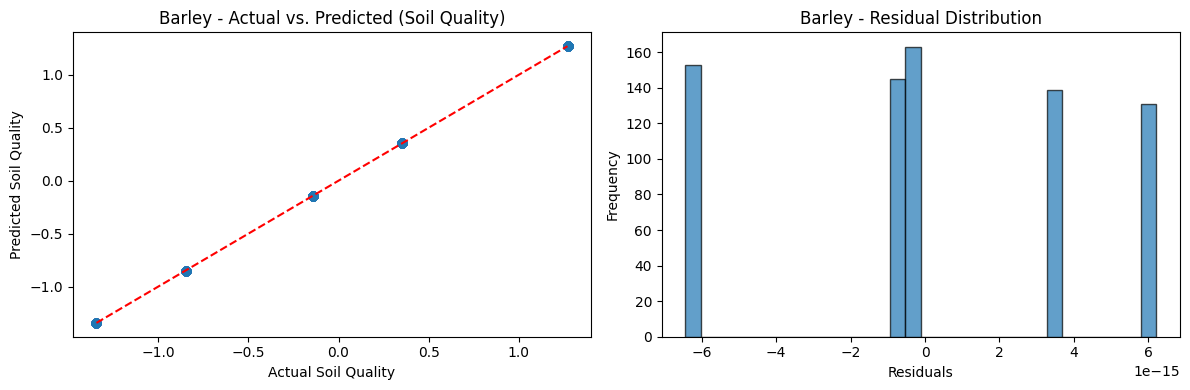

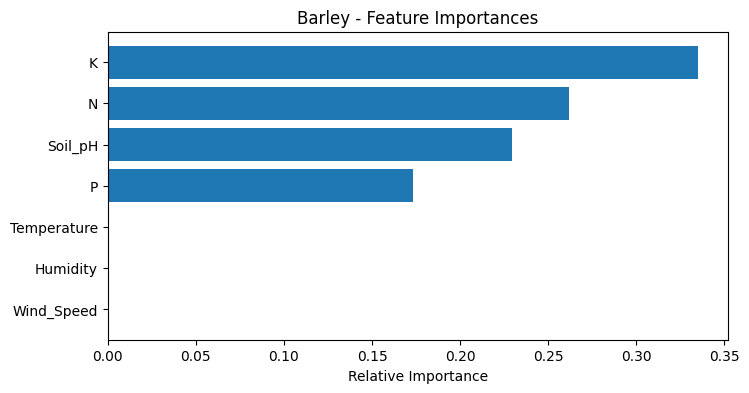

Soil quality forecast for Barley saved as 'barley_soil_quality_forecast.csv'.

Training Random Forest model for crop: Soybean
Best parameters for Soybean: {'max_depth': 5, 'n_estimators': 200}
Soybean - Random Forest Test MSE: 0.0000, MAE: 0.0000


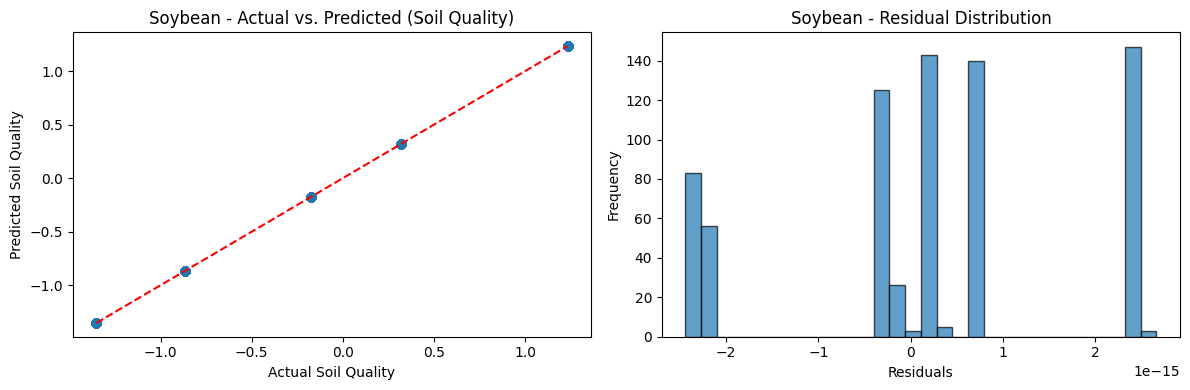

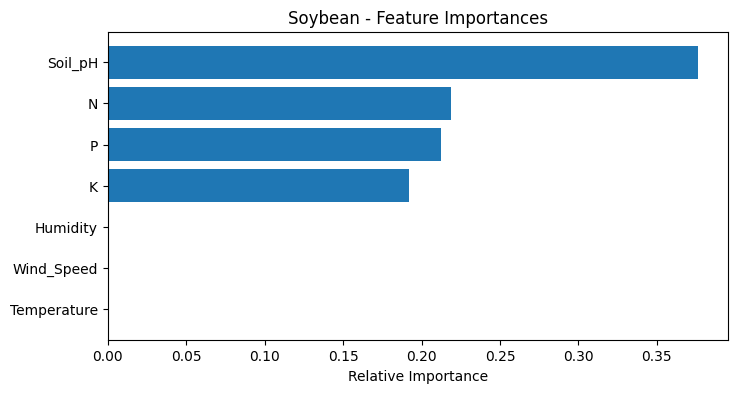

Soil quality forecast for Soybean saved as 'soybean_soil_quality_forecast.csv'.

Training Random Forest model for crop: Cotton
Best parameters for Cotton: {'max_depth': None, 'n_estimators': 50}
Cotton - Random Forest Test MSE: 0.0000, MAE: 0.0000


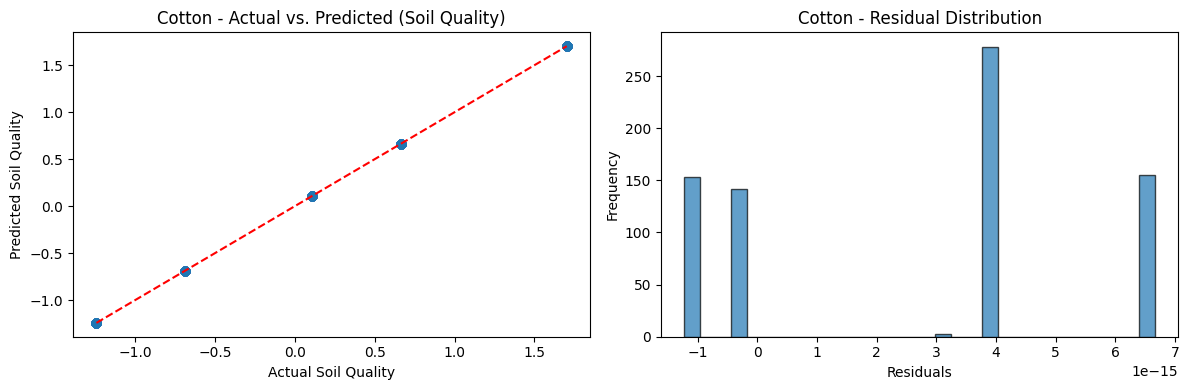

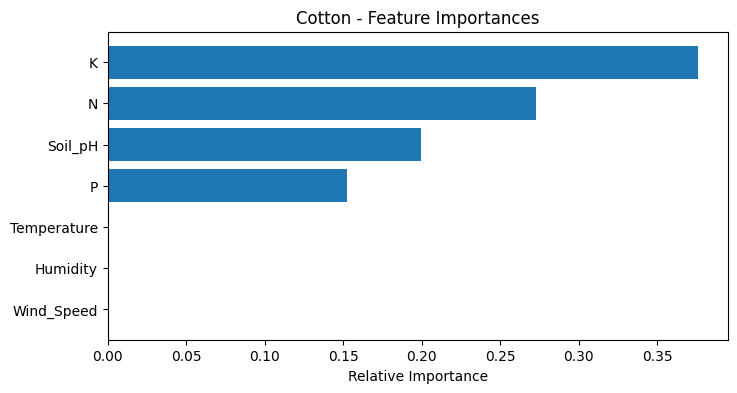

Soil quality forecast for Cotton saved as 'cotton_soil_quality_forecast.csv'.

Training Random Forest model for crop: Sugarcane
Best parameters for Sugarcane: {'max_depth': 5, 'n_estimators': 100}
Sugarcane - Random Forest Test MSE: 0.0000, MAE: 0.0000


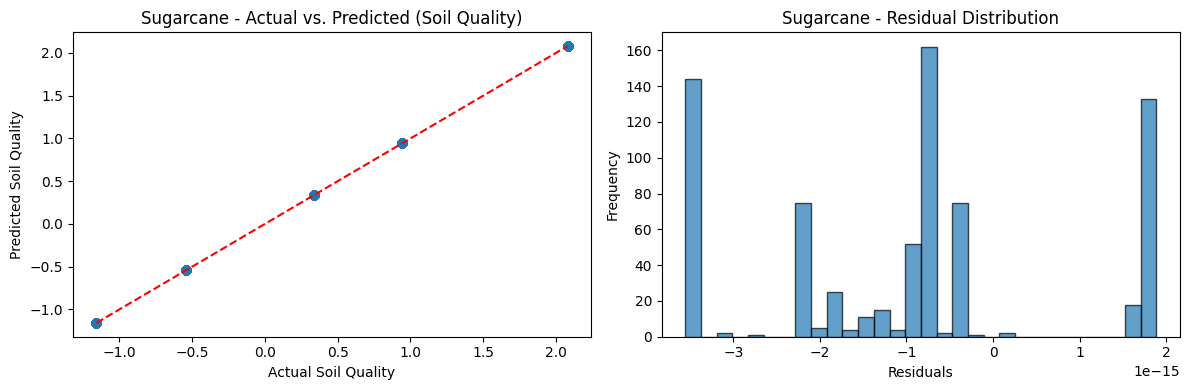

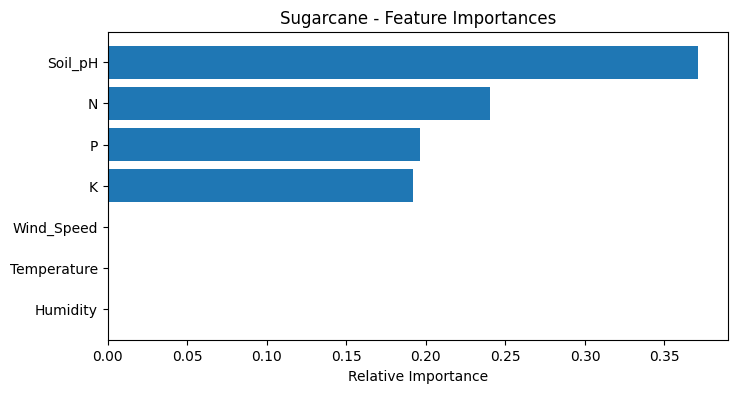

Soil quality forecast for Sugarcane saved as 'sugarcane_soil_quality_forecast.csv'.

Training Random Forest model for crop: Tomato
Best parameters for Tomato: {'max_depth': None, 'n_estimators': 100}
Tomato - Random Forest Test MSE: 0.0000, MAE: 0.0000


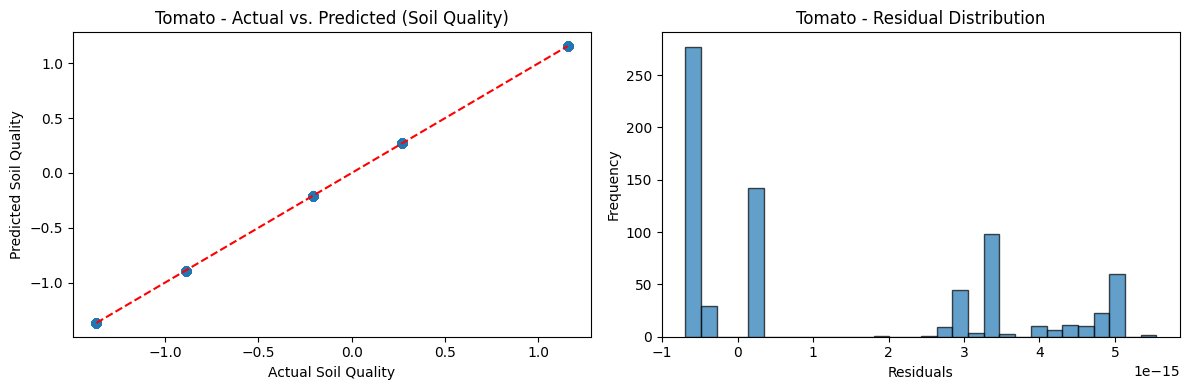

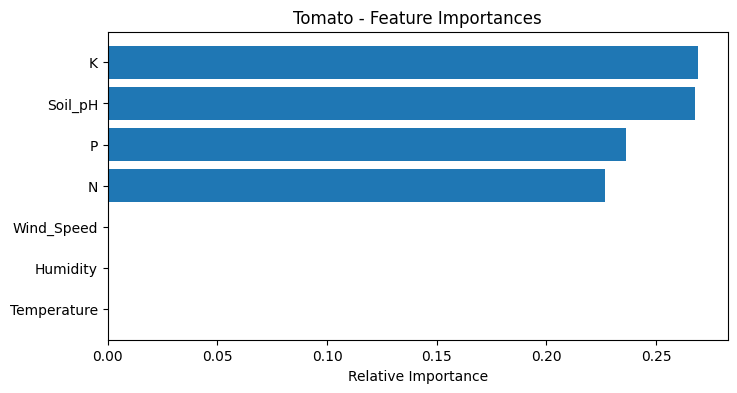

Soil quality forecast for Tomato saved as 'tomato_soil_quality_forecast.csv'.

Training Random Forest model for crop: Potato
Best parameters for Potato: {'max_depth': 5, 'n_estimators': 50}
Potato - Random Forest Test MSE: 0.0000, MAE: 0.0000


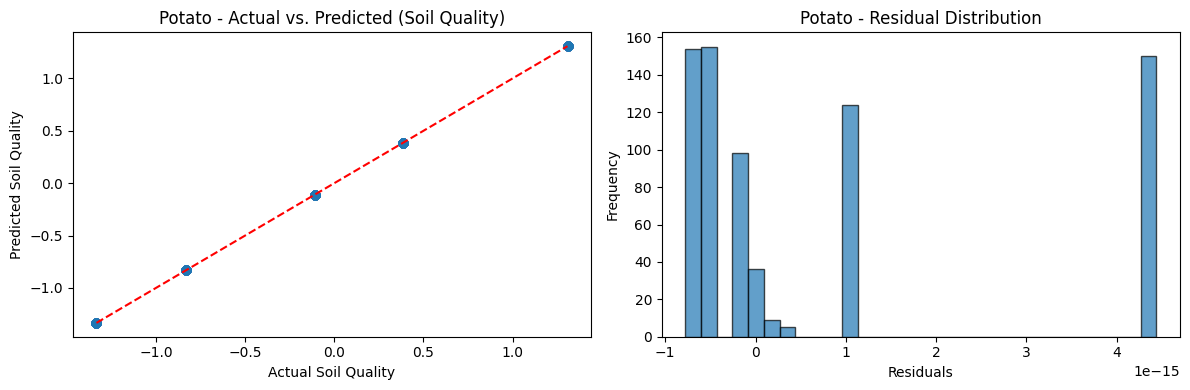

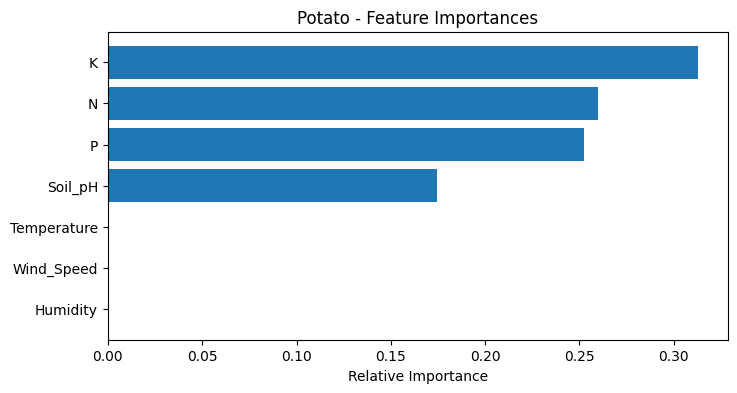

Soil quality forecast for Potato saved as 'potato_soil_quality_forecast.csv'.

Training Random Forest model for crop: Sunflower
Best parameters for Sunflower: {'max_depth': None, 'n_estimators': 50}
Sunflower - Random Forest Test MSE: 0.0000, MAE: 0.0000


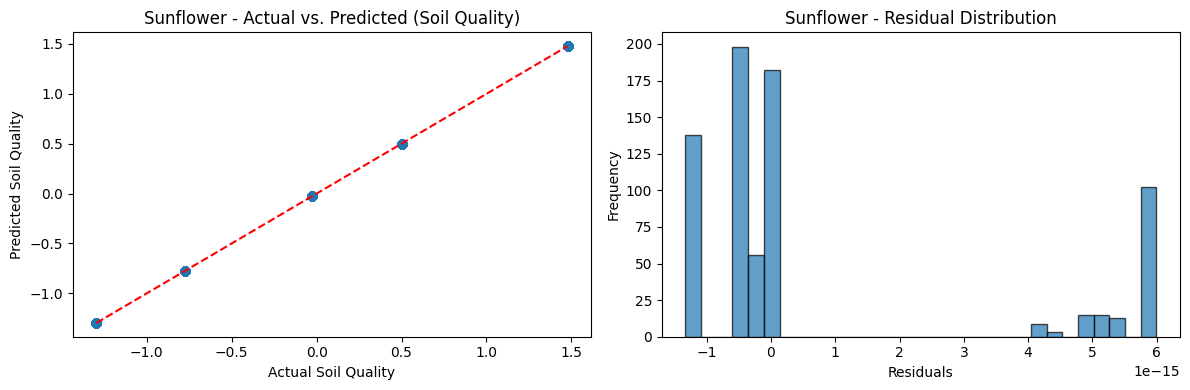

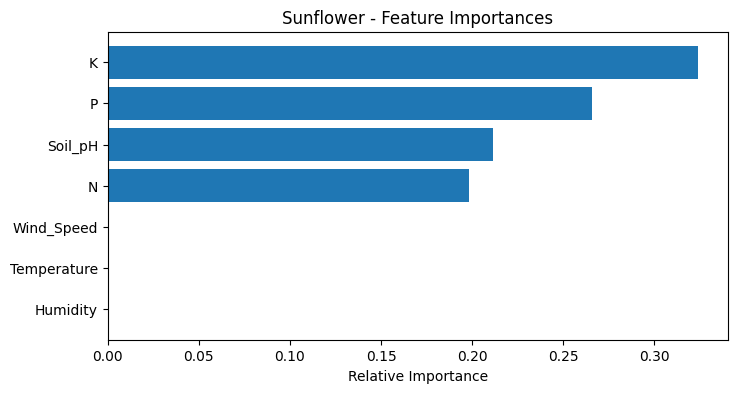

Soil quality forecast for Sunflower saved as 'sunflower_soil_quality_forecast.csv'.
Combined soil quality forecast saved as 'all_soil_quality_forecasts.csv'.


In [16]:
#############################################
# 3. Random Forest Model for Soil Quality Prediction
#############################################

# Define features and target for the Random Forest model.
rf_features = ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K']
rf_target = 'Soil_Quality'
num_future_days = 180  # Forecast horizon (6 months)

# Define a hyperparameter grid for tuning.
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}

# Get unique crop types (using the preserved original crop type column).
unique_crop_types = processed_data['Crop_Type_Orig'].unique()
all_soil_quality_forecasts = []  # To store forecast DataFrames for each crop

for crop in unique_crop_types:
    print(f"\nTraining Random Forest model for crop: {crop}")

    # Filter data for the current crop type.
    crop_data = processed_data[processed_data['Crop_Type_Orig'] == crop].copy()
    crop_data.sort_values('Date', inplace=True)

    # Ensure there is enough data.
    if len(crop_data) < 10:
        print(f"Not enough data for crop: {crop}. Skipping.")
        continue

    # Select features and target.
    X_rf = crop_data[rf_features]
    y_rf = crop_data[rf_target]

    # Split data into training and testing sets.
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

    # Set up GridSearchCV for hyperparameter tuning.
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_rf, y_train_rf)

    best_rf = grid_search.best_estimator_
    print(f"Best parameters for {crop}: {grid_search.best_params_}")

    # Evaluate performance on the test set.
    y_pred_test = best_rf.predict(X_test_rf)
    mse_rf = mean_squared_error(y_test_rf, y_pred_test)
    mae_rf = mean_absolute_error(y_test_rf, y_pred_test)
    print(f"{crop} - Random Forest Test MSE: {mse_rf:.4f}, MAE: {mae_rf:.4f}")

    # Visualization: Actual vs. Predicted and Residuals.
    plt.figure(figsize=(12, 4))

    # Scatter plot: Actual vs. Predicted.
    plt.subplot(1, 2, 1)
    plt.scatter(y_test_rf, y_pred_test, alpha=0.6)
    plt.plot([y_test_rf.min(), y_test_rf.max()], [y_test_rf.min(), y_test_rf.max()], 'r--')
    plt.title(f"{crop} - Actual vs. Predicted (Soil Quality)")
    plt.xlabel("Actual Soil Quality")
    plt.ylabel("Predicted Soil Quality")

    # Histogram: Residuals.
    residuals = y_test_rf - y_pred_test
    plt.subplot(1, 2, 2)
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.title(f"{crop} - Residual Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    # Visualization: Feature Importances.
    importances = best_rf.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(8, 4))
    plt.title(f"{crop} - Feature Importances")
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [rf_features[i] for i in indices])
    plt.xlabel("Relative Importance")
    plt.show()

    # Forecast soil quality 6 months into the future.
    # To avoid warnings, get the last row as a DataFrame.
    last_features = X_rf.iloc[[-1]]
    future_soil_quality_preds = []
    for _ in range(num_future_days):
        pred_soil = best_rf.predict(last_features)[0]
        future_soil_quality_preds.append(pred_soil)
        # Optionally update last_features if future feature evolution is available.

    # Prepare forecast dates.
    last_date_rf = crop_data['Date'].max()
    future_dates_rf = [pd.to_datetime(last_date_rf) + timedelta(days=i+1) for i in range(num_future_days)]

    # Create DataFrame with the forecast for this crop.
    soil_quality_forecast = pd.DataFrame({
        'Date': future_dates_rf,
        'Crop_Type': crop,
        'Predicted_Soil_Quality': future_soil_quality_preds
    })

    # Save individual forecast to CSV.
    forecast_filename = f"{crop.lower().replace(' ', '_')}_soil_quality_forecast.csv"
    soil_quality_forecast.to_csv(forecast_filename, index=False)
    print(f"Soil quality forecast for {crop} saved as '{forecast_filename}'.")

    all_soil_quality_forecasts.append(soil_quality_forecast)

# Optionally, combine all crop-specific forecasts into one CSV.
if all_soil_quality_forecasts:
    combined_soil_forecast = pd.concat(all_soil_quality_forecasts, ignore_index=True)
    combined_soil_forecast.to_csv("all_soil_quality_forecasts.csv", index=False)
    print("Combined soil quality forecast saved as 'all_soil_quality_forecasts.csv'.")

Saving it all into a CSV file to Import into Tableau for Dashboard Creation

In [20]:
# --- Step 1: Prepare Historical Data ---
# Assume 'processed_data' is your DataFrame with actual values.
# Columns expected: Date, Crop_Type_Orig, Crop_Yield, Soil_Quality, etc.
historical_data = processed_data[['Date', 'Crop_Type_Orig', 'Crop_Yield', 'Soil_Quality']].copy()
historical_data = historical_data.rename(columns={
    'Crop_Type_Orig': 'Crop_Type',
    'Crop_Yield': 'Actual_Crop_Yield',
    'Soil_Quality': 'Actual_Soil_Quality'
})
historical_data['Date'] = pd.to_datetime(historical_data['Date'])
# For historical rows, predicted columns are not available.
historical_data['Predicted_Crop_Yield'] = pd.NA
historical_data['Predicted_Soil_Quality'] = pd.NA

# Define common column order
common_columns = ['Date', 'Crop_Type', 'Actual_Crop_Yield', 'Predicted_Crop_Yield',
                  'Actual_Soil_Quality', 'Predicted_Soil_Quality']

# Reindex historical data to ensure all columns exist
historical_data = historical_data.reindex(columns=common_columns)

# --- Step 2: Read Combined Forecast Files ---
# These files were previously saved as:
# "all_crop_yield_forecasts.csv" and "all_soil_quality_forecasts.csv"
yield_forecast_combined = pd.read_csv("all_crop_yield_forecasts.csv")
soil_forecast_combined = pd.read_csv("all_soil_quality_forecasts.csv")

# Ensure Date columns are datetime.
yield_forecast_combined['Date'] = pd.to_datetime(yield_forecast_combined['Date'])
soil_forecast_combined['Date'] = pd.to_datetime(soil_forecast_combined['Date'])

# Merge the two forecast DataFrames on Date and Crop_Type.
forecast_df = pd.merge(yield_forecast_combined, soil_forecast_combined,
                       on=['Date', 'Crop_Type'], how='outer')

# For forecast rows, actual values are not available.
forecast_df['Actual_Crop_Yield'] = pd.NA
forecast_df['Actual_Soil_Quality'] = pd.NA

# Reorder columns to the common set.
forecast_df = forecast_df.reindex(columns=common_columns)

# --- Step 3: Combine Historical and Forecast Data ---
combined_df = pd.concat([historical_data, forecast_df], ignore_index=True)
combined_df = combined_df.sort_values(['Crop_Type', 'Date'])

# Save the final combined DataFrame to CSV.
combined_df.to_csv("harvestsense_combined_forecasts.csv", index=False)
print("Combined forecasts saved as 'harvestsense_combined_forecasts.csv'.")

<ipython-input-20-9bc19049684e>:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat([historical_data, forecast_df], ignore_index=True)


Combined forecasts saved as 'harvestsense_combined_forecasts.csv'.


In [36]:
# Load the combined forecasts CSV (created from historical and forecast data)
df = pd.read_csv("harvestsense_combined_forecasts.csv")

# Ensure the forecast columns are numeric (they may be missing for historical or forecast rows)
df['Actual_Crop_Yield'] = pd.to_numeric(df['Actual_Crop_Yield'], errors='coerce')
df['Predicted_Crop_Yield'] = pd.to_numeric(df['Predicted_Crop_Yield'], errors='coerce')
df['Actual_Soil_Quality'] = pd.to_numeric(df['Actual_Soil_Quality'], errors='coerce')
df['Predicted_Soil_Quality'] = pd.to_numeric(df['Predicted_Soil_Quality'], errors='coerce')

# Define the original order used in scaling
num_features = ['Soil_pH', 'Temperature', 'Humidity', 'Wind_Speed', 'N', 'P', 'K', 'Crop_Yield', 'Soil_Quality']
yield_idx = num_features.index('Crop_Yield')      # should be 7
soil_idx = num_features.index('Soil_Quality')       # should be 8

# Inverse-transform the scaled values back to original units.
# (Assumes 'scaler' is the StandardScaler instance used earlier.)
df['Actual_Crop_Yield'] = df['Actual_Crop_Yield'] * scaler.scale_[yield_idx] + scaler.mean_[yield_idx]
df['Predicted_Crop_Yield'] = df['Predicted_Crop_Yield'] * scaler.scale_[yield_idx] + scaler.mean_[yield_idx]
df['Actual_Soil_Quality'] = df['Actual_Soil_Quality'] * scaler.scale_[soil_idx] + scaler.mean_[soil_idx]
df['Predicted_Soil_Quality'] = df['Predicted_Soil_Quality'] * scaler.scale_[soil_idx] + scaler.mean_[soil_idx]

# Save the new CSV file with values in the original units
df.to_csv("harvestsense_combined_forecasts_original_units.csv", index=False)
print("Resaved CSV with original units as 'harvestsense_combined_forecasts_original_units.csv'.")

Resaved CSV with original units as 'harvestsense_combined_forecasts_original_units.csv'.


In [37]:
# Download the CSV file
files.download("harvestsense_combined_forecasts_original_units.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>